<a href="https://colab.research.google.com/github/girishsenthil/NLP/blob/main/roBERTa_with_NLG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# roBERTa Model Build for Text Emotion Classification!

## Importing Packages/Downloading Data

### Downloading Data

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 112MB/s]


### Imports

In [6]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.4 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 
     |████████████████████████████████| 101 kB 9.6 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import pandas as pd
import numpy as np
import tokenizers
import torch
import transformers
import torch.nn as nn
from torch.nn import functional, BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

from transformers import RobertaConfig, RobertaModel
import logging

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

In [8]:
import zipfile
import os

## Data EDA

### Creating DataFrames

In [9]:
# Extracting train, test, val  .txt files from emotions-dataset-for-nlp.zip
with zipfile.ZipFile('/content/emotions-dataset-for-nlp.zip') as zip:
  zip.extractall()

In [10]:
#init dataframes
delimiter = ';'
names = ['sentence', 'label']

test_df = pd.read_csv('/content/test.txt', delimiter = delimiter, 
                      header = None, names = names)


train_df = pd.read_csv('/content/train.txt', delimiter = delimiter,
                       header = None, names = names)

val_df = pd.read_csv('/content/val.txt', delimiter = delimiter,
                     header = None, names = names)

In [11]:
train_df.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [12]:
train_df.shape, test_df.shape, val_df.shape

((16000, 2), (2000, 2), (2000, 2))

### Data Visualization

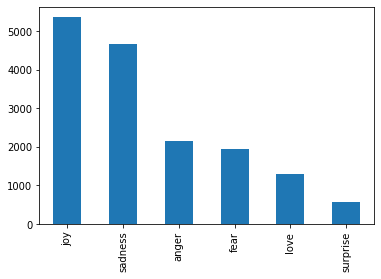

In [13]:
train_df['label'].value_counts().plot.bar()

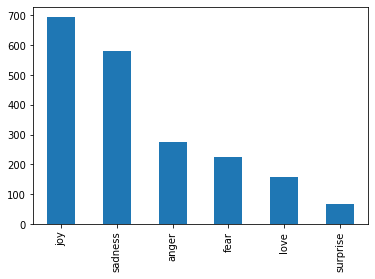

In [14]:
test_df['label'].value_counts().plot.bar()

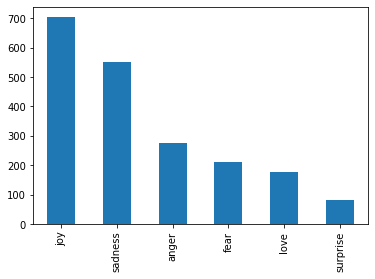

In [15]:
val_df['label'].value_counts().plot.bar()

As can be seen in the graph, there is a large class inbalance. 

In [16]:
num_labels = len(np.unique(train_df['label']))
print(num_labels)

6


## Data Preparation

### Tokenizer and OneHotEncoder Functions

In [18]:
def tokens_and_masks(inputs, tokenizer, max_length = 90):

  input_ids, attention_masks = [], []

  for sentence in tqdm(inputs):
    output_dict = tokenizer.encode_plus(text = sentence,
                                padding = 'max_length',
                                truncation = True,
                                max_length = 90)
    
    input_ids.append(output_dict['input_ids'])
    attention_masks.append(output_dict['attention_mask'])
  
  return input_ids, attention_masks


Made my own One Hot Encoder for ease of use. SkLearn OHE is not very satisfying to use.

In [19]:
class one_hot_encoder:
  def __init__(self):
    self.encoding_dict = {}

  def get_encoding_dict(self):
    return self.encoding_dict

  def fit(self, dataframe_column):

    to_encode = dataframe_column.unique()
    encoding_dict = {label:[] for label in to_encode}
    encoding_length = len(encoding_dict.keys())

    for i, j in list(enumerate(encoding_dict.keys())):
      encoding_arr = [0] * encoding_length
      encoding_arr[i] = 1
      encoding_dict[j] = encoding_arr

    self.encoding_dict = encoding_dict

    return encoding_dict

  def transform(self, dataframe_column):
    
    transformed_column = list(map(lambda x: self.encoding_dict[x], dataframe_column))
    return transformed_column

  def decode(self, target):

    decoded_target = []

    for encoded_label in target:
      
      try:
        vals = list(self.encoding_dict.values())
        keys = list(self.encoding_dict.keys())

        key_pos = vals.index(encoded_label)
        decoded_label = keys[key_pos]

        decoded_target.append(decoded_label)

      except ValueError:
        decoded_target.append('NoPred')

    return decoded_target


In [17]:
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base', do_lower_case = True)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

### Processing Data

In [20]:
train_df['input_ids'], train_df['mask'] = tokens_and_masks(train_df['sentence'].values, tokenizer = tokenizer)
val_df['input_ids'], val_df['mask'] = tokens_and_masks(val_df['sentence'].values, tokenizer = tokenizer)

100%|██████████| 2000/2000 [00:00<00:00, 2573.50it/s]


In [21]:
ohe = one_hot_encoder()

In [22]:
ohe.fit(train_df['label'])

{'anger': [0, 1, 0, 0, 0, 0],
 'fear': [0, 0, 0, 0, 1, 0],
 'joy': [0, 0, 0, 0, 0, 1],
 'love': [0, 0, 1, 0, 0, 0],
 'sadness': [1, 0, 0, 0, 0, 0],
 'surprise': [0, 0, 0, 1, 0, 0]}

In [23]:
test = ohe.get_encoding_dict()

In [24]:
train_df['enc_label'] = ohe.transform(train_df['label'])
val_df['enc_label'] = ohe.transform(val_df['label'])

In [25]:
train_df.head()

,sentence,label,input_ids,mask,enc_label
0,i didnt feel humiliated,sadness,"[0, 118, 46405, 619, 32386, 2, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0]"
1,i can go from feeling so hopeless to so damned...,sadness,"[0, 118, 64, 213, 31, 2157, 98, 24418, 7, 98, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0]"
2,im grabbing a minute to post i feel greedy wrong,anger,"[0, 757, 16004, 10, 2289, 7, 618, 939, 619, 34...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]"
3,i am ever feeling nostalgic about the fireplac...,love,"[0, 118, 524, 655, 2157, 28055, 59, 5, 24672, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0]"
4,i am feeling grouchy,anger,"[0, 118, 524, 2157, 22970, 17414, 2, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]"


In [26]:
test = ohe.decode(train_df['enc_label'])

In [27]:
all(test == train_df['label'])

True

### Converting Data to Tensors

In [28]:
X_train = train_df['input_ids'].tolist()
train_masks = train_df['mask'].tolist()
y_train = train_df['enc_label'].tolist()

In [29]:
X_valid = val_df['input_ids'].tolist()
val_masks = val_df['mask'].tolist()
y_val = val_df['enc_label'].tolist()

In [30]:
X_train = torch.tensor(X_train)
train_masks = torch.tensor(train_masks, dtype = torch.long)
y_train = torch.tensor(y_train, dtype = torch.float32)

In [31]:
train_data = TensorDataset(X_train, train_masks, y_train)

In [32]:
X_valid = torch.tensor(X_valid)
val_masks = torch.tensor(val_masks, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.float32)

In [33]:
val_data = TensorDataset(X_valid, val_masks, y_val)

In [34]:
train_params = {'batch_size': 8,
                'shuffle': True,
                'num_workers': 0}

val_params = {'batch_size': 16,
              'shuffle': True,
              'num_workers': 0}

In [35]:
train_dataloader = DataLoader(train_data, **train_params)
val_dataloader = DataLoader(val_data, **val_params)

## Model Initialization

In [60]:
class Roberta(torch.nn.Module):

  def __init__(self, num_labels):
    super(Roberta, self).__init__()

    self.l1 = RobertaModel.from_pretrained('roberta-base')
    self.pre_classifier = torch.nn.Linear(768, 768)
    self.dropout = torch.nn.Dropout(0.25)
    self.num_labels = num_labels
    self.classifier = torch.nn.Linear(768, num_labels)
    self.loss = torch.nn.BCEWithLogitsLoss()
  
  def forward(self, input_ids, token_type_ids = None, 
              attention_mask = None, labels = None):
    
    output_1 = self.l1(input_ids = input_ids, attention_mask = attention_mask,
                       token_type_ids = token_type_ids)
    hidden_state = output_1[0]
    pooled_layer = hidden_state[:, 0]

    l2 = self.pre_classifier(pooled_layer)
    activation = torch.nn.ReLU()(l2)
    l2_dropout = self.dropout(activation)
    logits = self.classifier(l2_dropout)
    if labels is None:
      return logits
    else:
      bce_loss = self.loss(logits.view(-1, self.num_labels), 
                          labels.view(-1, self.num_labels))
      
      return bce_loss

  def save_model(self, model, model_save_path, epoch, lowest_eval_loss,
                 total_training_loss, total_validation_loss):
    
    save_dict = {'state': model.module if hasattr(model, 'module') else model,
                 'epoch': epoch,
                 'lowest_eval_loss': lowest_eval_loss,
                 'total_training_loss': total_training_loss,
                 'total_validation_loss': total_validation_loss}
    
    torch.save(save_dict, model_save_path)

    print(f'Saved Model; Epoch: {epoch}, Validation Loss: {lowest_eval_loss}')

    return


In [61]:
def train_model(model, num_epochs, optimizer, train_dataloader, val_dataloader,
                model_save_path, device):
  
  model.to(device)

  total_training_loss, total_validation_loss = [], []
  lowest_eval_loss = None

  for epoch in range(num_epochs):

    #set model to train
    model.train()

    training_loss = 0
    trained_samples = 0

    for step, batch in enumerate(train_dataloader):

      batch = tuple(t.to(device) for t in batch)
      batch_ids, batch_masks, batch_labels = batch

      optimizer.zero_grad()
      loss = model(batch_ids, attention_mask = batch_masks, labels = batch_labels)
      training_loss += loss.item()
      trained_samples += batch_labels.size(0)

      loss.backward()
      optimizer.step()

    training_epoch_loss = training_loss/trained_samples
    total_training_loss.append(training_epoch_loss)

    print(f'Epoch Train Loss: {training_epoch_loss}')

    #validation, set model to eval and torch.no_grad() to prevent gradient usage

    model.eval()
    eval_loss = 0
    eval_samples = 0

    for batch in val_dataloader:

      batch = tuple(t.to(device) for t in batch)
      batch_ids, batch_masks, batch_labels = batch

      with torch.no_grad():

        loss = model(batch_ids, attention_mask = batch_masks, labels = batch_labels)
        eval_loss += loss.item()
        eval_samples += batch_labels.size(0)

    val_epoch_loss = eval_loss/eval_samples
    total_validation_loss.append(val_epoch_loss)

    print(f'Epoch Val Loss: {val_epoch_loss}')

    if lowest_eval_loss is None:

      lowest_eval_loss = val_epoch_loss
      model.save_model(model, model_save_path, epoch, lowest_eval_loss,
                       total_training_loss, total_validation_loss)

    else:

      if val_epoch_loss < lowest_eval_loss:

        lowest_eval_loss = val_epoch_loss
        model.save_model(model, model_save_path, epoch, lowest_eval_loss,
                       total_training_loss, total_validation_loss)
    
    
  return model, total_training_loss, total_validation_loss


In [62]:
model = Roberta(num_labels = num_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Model Training and Inference

### Training

In [47]:
model_save_path = os.getcwd() + '/roberta_model.bin'

In [48]:
print(f'Saving Model at {model_save_path}')

Saving Model at /content/roberta_model.bin


In [63]:
num_epochs = 4
optimizer = torch.optim.AdamW(params = model.parameters(), lr = 1e-5)

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [65]:
model, total_training_loss, total_validation_loss = train_model(model = model,
                                                                num_epochs = num_epochs,
                                                                optimizer = optimizer,
                                                                train_dataloader = train_dataloader,
                                                                val_dataloader = val_dataloader,
                                                                model_save_path = model_save_path,
                                                                device = device)

Epoch Train Loss: 0.02140681853488786
Epoch Val Loss: 0.004182882390450686
Saved Model; Epoch: 0, Validation Loss: 0.004182882390450686
Epoch Train Loss: 0.0075409237790445335
Epoch Val Loss: 0.003025916109443642
Saved Model; Epoch: 1, Validation Loss: 0.003025916109443642
Epoch Train Loss: 0.005162647066441423
Epoch Val Loss: 0.00245111336739501
Saved Model; Epoch: 2, Validation Loss: 0.00245111336739501
Epoch Train Loss: 0.004524585342773208
Epoch Val Loss: 0.0024264259198389483
Saved Model; Epoch: 3, Validation Loss: 0.0024264259198389483


### Model Inference

In [53]:
test_df['input_ids'], test_df['mask'] = tokens_and_masks(test_df['sentence'].values, tokenizer = tokenizer)

100%|██████████| 2000/2000 [00:00<00:00, 2010.05it/s]


In [54]:
test_df.head()

,sentence,label,input_ids,mask
0,im feeling rather rotten so im not very ambiti...,sadness,"[0, 757, 2157, 1195, 34485, 98, 4356, 45, 182,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
1,im updating my blog because i feel shitty,sadness,"[0, 757, 18796, 127, 5059, 142, 939, 619, 4381...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
2,i never make her separate from me because i do...,sadness,"[0, 118, 393, 146, 69, 2559, 31, 162, 142, 939...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,i left with my bouquet of red and yellow tulip...,joy,"[0, 118, 314, 19, 127, 20437, 15259, 9, 1275, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,i was feeling a little vain when i did this one,sadness,"[0, 118, 21, 2157, 10, 410, 25876, 77, 939, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."


In [85]:
def test_model(model, test_df, num_labels, device, batch_size = 20):

  num_iter = test_df.shape[0]//batch_size
  pred_probs = np.array([]).reshape(0, num_labels)

  model.to(device)
  model.eval()

  for test_epoch in tqdm(range(num_iter)):

    batch = test_df.iloc[test_epoch*batch_size:(test_epoch + 1)*batch_size, :]

    X = batch['input_ids'].tolist()
    masks = batch['mask'].tolist()
    
    X, masks = torch.tensor(X), torch.tensor(masks, dtype = torch.long)
    X = X.to(device)
    masks = masks.to(device)

    with torch.no_grad():
      logits = model(input_ids = X, attention_mask = masks)
      logits = logits.sigmoid().detach().cpu().numpy()

      pred_probs = np.vstack([pred_probs, np.round(logits)])

  return pred_probs
      

In [86]:
pred = test_model(model = model, test_df = test_df, 
                  num_labels = num_labels, device = device)

100%|██████████| 100/100 [00:05<00:00, 16.93it/s]


In [ ]:
pred.astype(int).tolist()

In [122]:
def decode(target):

  decoded_target = []

  for encoded_label in target:
    try:
      vals = list(ohe.encoding_dict.values())
      keys = list(ohe.encoding_dict.keys())
      
      key_pos = vals.index(encoded_label)
      
      decoded_label = keys[key_pos]
      decoded_target.append(decoded_label)

    except ValueError:
      decoded_target.append('NoPred')
      
  return decoded_target



In [123]:
decoded_labels = decode(pred.astype(int).tolist())

In [125]:
test_df['preds'] = decoded_labels

In [131]:
corr = test_df['label'] == test_df['preds']
test_acc = corr.sum()/len(corr)

In [132]:
print(f'Test Accuracy {test_acc}')

Test Accuracy 0.92


In [139]:
misclassified = test_df.loc[~corr][['label', 'preds']]

In [140]:
misclassified.value_counts()

label     preds   
love      joy         44
sadness   NoPred      13
anger     fear        11
fear      NoPred      11
surprise  fear        11
anger     sadness     10
surprise  joy          9
joy       love         9
fear      sadness      8
          surprise     7
anger     NoPred       6
sadness   anger        4
joy       NoPred       4
          sadness      3
surprise  NoPred       3
sadness   fear         2
anger     joy          2
sadness   joy          1
surprise  love         1
          sadness      1
dtype: int64

It is reasonable to see that the Roberta Model incorrectly classifies love as joy in certain instances, as the emotional context is not mutually exclusive between the two.

Perhaps due to the lack of training data for negative emotions of Fear, Anger, and Sadness, the training model did not place much weight upon misclassifying these. 

A way to overcome this would be to initialize the BCE Loss with a weight tensor, or creating an NLG model to boost the training data with generated sentences and labels.
